# Implement names generator

Use architecture from Bengio et al

In [1]:
import time

import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def move_to_device(tensors, device):
    new_tensors = [None] * len(tensors)
    for idx, tensor in enumerate(tensors):
        new_tensors[idx] = tensor.to(device)
    return new_tensors

In [3]:
device = torch.device('cuda', 0)

Prepare dataset:

In [4]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()


In [5]:
block_size = 3

In [6]:
all_letters = set(sum((list(s) for s in words), []))

In [7]:
all_symbols = all_letters.union({'.'})
stoi = {'.': 0}
stoi.update({letter: idx for idx, letter in enumerate(all_letters, 1)})

# create dataset
X = list()
y = list()
for word in words:
    word = block_size * '.' + word + '.'
    for idx in range(block_size, len(word)):
        prev = word[(idx-block_size):idx]
        X.append(list(stoi[s] for s in prev))
        y.append(stoi[word[idx]])

X = torch.tensor(X, device=device)
y = torch.tensor(y, device=device)

In [8]:
def split_dataset(X, y):
    total_len = X.shape[0]
    num_tr = round(0.6 * total_len)
    num_val = round(0.2 * total_len)
    num_test = total_len - num_tr - num_val
    idx_tr, idx_val, idx_test = torch.utils.data.random_split(range(X.shape[0]), [num_tr, num_val, num_test])
    return (X[idx_tr], y[idx_tr]), (X[idx_val], y[idx_val]), (X[idx_test], y[idx_test])

In [9]:
(Xtr, ytr), (Xval, yval), (Xtest, ytest) = split_dataset(X, y)

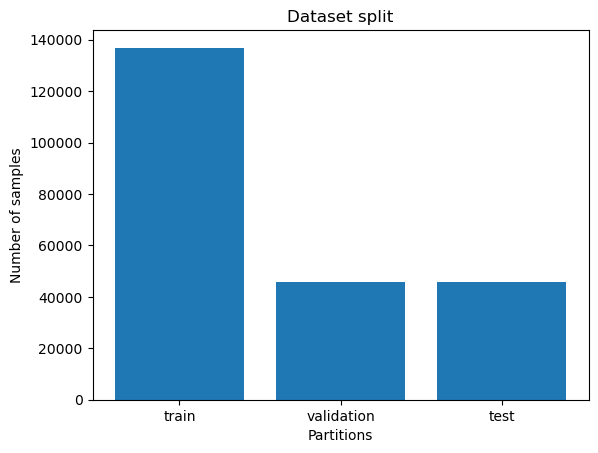

In [10]:
_, ax = plt.subplots(1, 1)
ax.set_title("Dataset split")
ax.set_xlabel("Partitions")
ax.set_ylabel("Number of samples")
ax.bar(['train', 'validation', 'test'], [len(Xtr), len(Xval), len(Xtest)])
plt.show()

In [11]:
embeddings_len = 60

In [51]:
# Initialize parameters
C = torch.randn((len(all_symbols), embeddings_len), device=device) # matrix of embeddings
C.requires_grad = True

hidden_nodes = 60

biases1 = torch.randn(hidden_nodes, device=device) * 0.01
biases1.requires_grad = True

weights1 = torch.randn((block_size * embeddings_len, hidden_nodes), device=device) * ((5 / 3) / np.sqrt(block_size * embeddings_len))
weights1.requires_grad = True

biases2 = torch.randn(len(all_symbols), device=device) * 0.01
biases2.requires_grad = True

weights2 = torch.randn((hidden_nodes, len(all_symbols)), device=device) * 0.01
weights2.requires_grad = True

parameters = [
    C, 
    biases1, 
    weights1, 
    biases2, 
    weights2
    ]

In [52]:
class Introspector:
    def __init__(self):
        self.first_layer_activations = None
        self.second_layer_activations = None
        self.third_layer_activations = None

In [53]:
introspector = Introspector()

In [54]:
def create_model(X: torch.Tensor):
    c = C[X]

    first_layer_volume = c.view(X.shape[0], -1)
    first_layer_activations = torch.tanh(first_layer_volume)

    second_layer_volume = (first_layer_activations @ weights1) + biases1
    second_layer_activations = torch.tanh(second_layer_volume)

    third_layer_volume = (second_layer_activations @ weights2) + biases2
    third_layer_activations = torch.softmax(third_layer_volume, 1)

    introspector.first_layer_activations = first_layer_activations
    introspector.second_layer_activations = second_layer_activations
    introspector.third_layer_activations = third_layer_activations

    return third_layer_activations

def create_loss(predictions, actual):
    return - predictions[range(len(predictions)), actual].log().mean()


In [55]:
# device = torch.device('cuda', 0)
device = torch.device('cpu')
C, biases1, weights1, biases2, weights2, Xtr, ytr = move_to_device(
    [
        C,
        biases1, 
        weights1, 
        biases2, 
        weights2,
        Xtr, ytr
    ],
    device
)

In [56]:
num_iters = 1000
batch_size = 32
lr = 0.01
# lr = 0.01 * (batch_size // 32)

ts = time.time()
for num_iter in range(num_iters):
    # get batch
    indices = torch.randint(0, len(Xtr) - 1, (batch_size,))
    batch_X = Xtr[indices]
    batch_y = ytr[indices]
    
    # calculate loss
    loss = create_loss(create_model(batch_X), batch_y)

    # display loss
    if (num_iter % 10) == 0:
        print(loss.item())

    # zerograd
    for parameter_tensor in parameters:
        parameter_tensor.grad = None

    # backprop
    loss.backward()
    
    # update weights
    for parameter_tensor in parameters:
        parameter_tensor.data -= lr * parameter_tensor.grad
    break
    print(f"Average time per iteration: {(time.time() - ts) / (num_iter + 1) * 1000:.2f} ms")

3.296905755996704


In [57]:
print('"Expected" loss:', -np.log(1 / len(all_symbols)))

"Expected" loss: 3.295836866004329


/tmp/ipykernel_4145982/1541678798.py:4: RuntimeWarning: divide by zero encountered in arctanh
  ax[0].scatter(np.arctanh(acts), acts, marker='.')


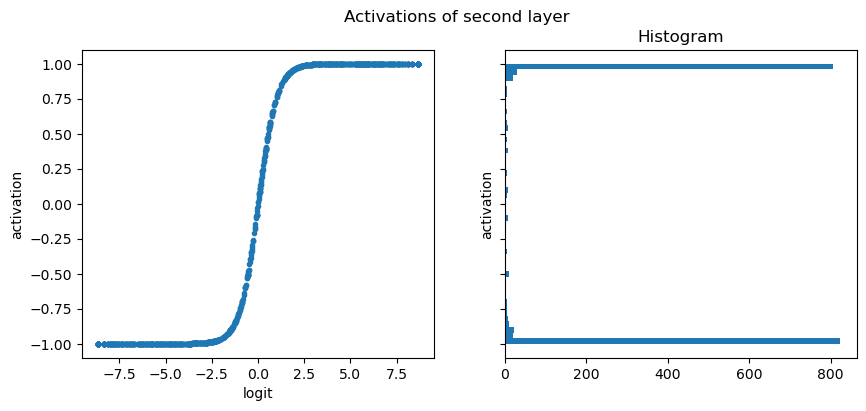

In [50]:
acts = introspector.second_layer_activations.detach().numpy().reshape(-1)
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle("Activations of second layer")
ax[0].scatter(np.arctanh(acts), acts, marker='.')
ax[0].set_xlabel('logit')
ax[0].set_ylabel('activation')
ax[1].set_title('Histogram')
ax[1].hist(acts, orientation='horizontal', bins=50)
ax[1].set_ylabel('activation')
plt.show()

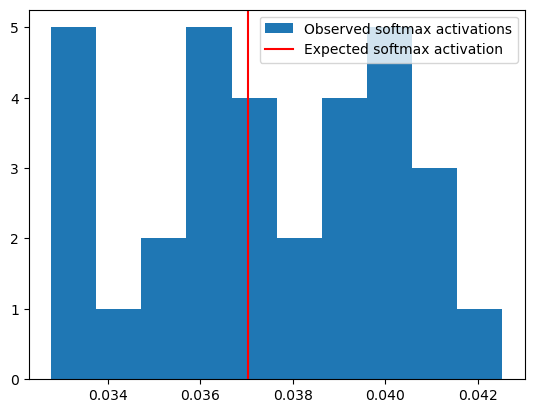

In [168]:
s = introspector.third_layer_activations[range(len(batch_y)), batch_y]
plt.figure()
plt.hist(s.detach().numpy(), label='Observed softmax activations')
plt.axvline(x=1/len(all_symbols), color='r', label='Expected softmax activation')
plt.legend()
plt.show()

In [ ]:
# Batch size 1024 * 4
# With GPU: 54 seconds
# With CPU: 79 seconds

In [110]:
def calc_loss(X, y):
    loss = create_loss(create_model(X), y)
    return loss.item()

In [112]:
tr_loss = calc_loss(Xtr, ytr)
val_loss = calc_loss(Xval, yval)
print("Train loss =", tr_loss)
print("Validation loss =", val_loss)

Train loss = 2.164073944091797
Validation loss = 2.217069149017334


In [81]:
torch.cuda.is_available()

False

In [23]:
# embeddings(60) + concatenate(3) + tanh + linear + softmax
# Train loss = 2.295232057571411
# Validation loss = 2.3178176879882812

# embeddings(60) + concatenate(3) + tanh + linear(10) + tanh + linear + softmax
# Train loss = 2.39597487449646
# Validation loss = 2.41440486907959

# embeddings(60) + concatenate(3) + tanh + linear(30) + tanh + linear + softmax
# Train loss = 2.303981065750122
# Validation loss = 2.3325693607330322

# embeddings(60) + concatenate(3) + tanh + linear(60) + tanh + linear + softmax
# Train loss = 2.164073944091797
# Validation loss = 2.217069149017334
# And still decreases